In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
#import scipy as sc

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
df=pd.read_csv("0.csv")
df1=pd.read_csv("0.csv")

df.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [2]:
df=df.drop('is_anomaly',axis=1)

In [3]:
new_data=pd.to_datetime(df['timestamp'],unit='s')
# from datetime import datetime
# for i in range(len(df.timestamp)):
#     df['timestamp'][i]=datetime.fromtimestamp(df['timestamp'][i])

In [4]:
df['timestamp']=new_data
df.head()

,timestamp,value,predicted
0,2015-02-27 03:42:53,42,44.072500
1,2015-02-27 03:47:53,41,50.709390
2,2015-02-27 03:52:53,41,81.405120
3,2015-02-27 03:57:53,61,39.950367
4,2015-02-27 04:02:53,44,35.350160


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  15830 non-null  datetime64[ns]
 1   value      15830 non-null  int64         
 2   predicted  15830 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 371.1 KB
None


In [6]:
print(df['timestamp'].tail())

15825   2015-04-23 02:27:53
15826   2015-04-23 02:32:53
15827   2015-04-23 02:37:53
15828   2015-04-23 02:42:53
15829   2015-04-23 02:47:53
Name: timestamp, dtype: datetime64[ns]


In [7]:
print(df['value'].mean())

85.57220467466836


<AxesSubplot:xlabel='timestamp'>

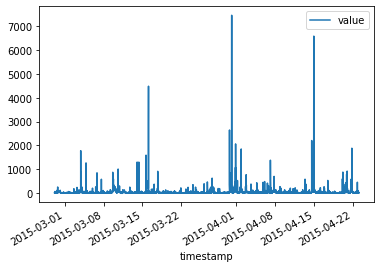

In [8]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

In [9]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [10]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [11]:
# df['time_epoch'] = (df['timestamp'].astype(np.int64)/1000000000).astype(np.int64)
df['time_epoch']=df1['timestamp']
df.time_epoch.head()

0    1425008573
1    1425008873
2    1425009173
3    1425009473
4    1425009773
Name: time_epoch, dtype: int64

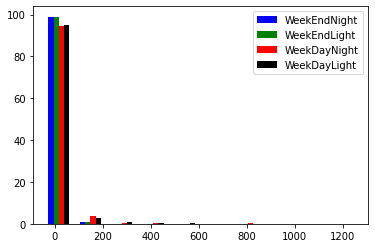

In [12]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [13]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

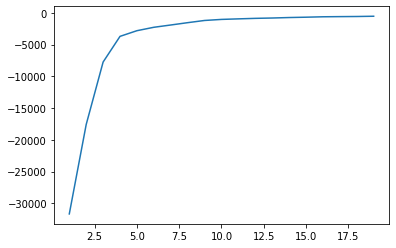

In [14]:
from sklearn.cluster import KMeans

# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [15]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()


12    1561
3     1343
5     1342
2     1248
13    1240
14    1152
6     1146
0     1128
4     1004
9      993
8      969
11     960
1      959
7      770
10      15
Name: cluster, dtype: int64

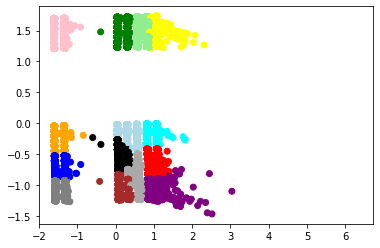

In [16]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()